# SageMaker shadow testing 

Amazon SageMaker now enables you to evaluate any changes to your model serving infrastructure, consisting of the ML model, the serving container, or the ML instance by shadow testing its performance against the currently deployed one. Shadow testing can help you catch potential configuration errors and performance issues before they impact end users. With SageMaker, you don’t need to invest in building your own shadow testing infrastructure, allowing you to focus on model development. 

You can use this to validate changes to any component to your production variant, namely the model, the container, or the instance, without any end user impact. It is useful in situations such as:

* You are considering promoting a new model that has been validated offline to production but want to evaluate operational performance metrics such as latency, error rate before making this decision
* You are considering changes to your serving infrastructure container, such as patching vulnerabilities or upgrading to newer versions, and want to assess the impact of these changes prior to promotion
* You are considering changing your ML instance and want to evaluate how the new instance would perform with live inference requests.

Just select a production variant you want to test against, and SageMaker automatically deploys the new variant in shadow mode and routes a copy of the inference requests to it in real time within the same endpoint. Only the responses of the production variant are returned to the calling application. You can choose to discard or log the responses of the shadow variant for offline comparison. 

This notebook provides a walkthrough of the feature using the SageMaker Inference APIs.  


## SageMaker Background

![title](images/Shadow.png)

A *production variant* consists of the ML model, Serving Container, and ML Instance. Since each variant is independent of others, you can have different models, containers, or instance types across variants. SageMaker lets you specify autoscaling policies on a per-variant basis so they can scale independently based on incoming load. SageMaker supports up to 10 production variants per endpoint. You can either configure a variant to receive a portion of the incoming traffic by setting variant weights or specify the target variant in the incoming request. The response from the production variant is forwarded back to the invoker.  

A *shadow variant* *(new)* has the same components as a production production variant. A user specified portion of the requests, known as the traffic sampling percentage (VariantWeight parameter in the ShadowProductionVariants object), is forwarded to the shadow variant. You can choose to log the response of the shadow variant in S3 or discard it. For an endpoint with a shadow variant, you can have a maximum of one production variant.  

You can monitor the [invocation metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html) for both production and shadow variants in CloudWatch under the AWS/SageMaker namespace 


## Setup 


Ensure that you have an updated version of boto3, which includes the latest SageMaker features:

In [4]:
!pip install sagemaker --quiet
!pip install -U awscli --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.2 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.131 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


The SageMaker role arn used to give training and hosting access to your data. The S3 bucket that you want to use for training and storing model objects.

In [11]:
import os
import boto3
import sagemaker
import time
from time import gmtime, strftime
from datetime import datetime, timedelta, timezone
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader
import utils

boto_session = boto3.session.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")


# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sagemaker.Session().default_bucket()

prefix = "sagemaker/shadow-deployment"
resource_name = "ShadowDemo-{}-{}"

In [5]:
%store
%store -r

Stored variables and their in-db values:
deploy_instance_type                  -> 'ml.m5.xlarge'
distilbert_model_name                 -> 'hf-pytorch-model-distilbert-2023-05-08-18-21-10'
model_data_path                       -> 's3://sagemaker-us-west-2-757967535041/sagemaker/h
model_distilbert_uri                  -> 's3://sagemaker-us-west-2-757967535041/sagemaker/h
model_package_group_name              -> 'HuggingFaceModels'
model_roberta_script_uri              -> 's3://sagemaker-us-west-2-757967535041/sagemaker/h
model_roberta_uri                     -> 's3://sagemaker-us-west-2-757967535041/sagemaker/h
roberta_model_name                    -> 'hf-pytorch-model-roberta-2023-05-08-18-21-08'
roberta_script_model_name             -> 'hf-pytorch-model-roberta-script-2023-05-08-18-37-


### Deploy the two models as production and shadow variants to a real-time Inference endpoint

The next step is to create an endpoint config with the production and shadow variants. The ProductionVariants and the ShadowProductionVariants are of particular interest. We set the InitialVariantWeight in the ShadowProductionVariants to sample and send 50% of the production variant requests to the shadow variant. The production variant receives 100% of the traffic.

Both these variants have ml.m5.xlarge instances with 4 vCPUs and 16 GiB of memory and the initial instance count is set to 1. 

In [25]:
ep_config_name = f"Shadow-EpConfig-{datetime.now():%Y-%m-%d-%H-%M-%S}"
production_variant_name = "production"
shadow_variant_name = "shadow"

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": production_variant_name,
            "ModelName": roberta_script_model_name,
            "InstanceType": deploy_instance_type,
            "InitialInstanceCount": 2,
            "InitialVariantWeight": 1,
        }
    ],
    ShadowProductionVariants=[
        {
            "VariantName": shadow_variant_name,
            "ModelName": roberta_model_name,
            "InstanceType": deploy_instance_type,
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 0.5,
        }
    ],
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-west-2:757967535041:endpoint-config/shadow-epconfig-2023-05-09-19-43-58


In [26]:
endpoint_name = f"xgb-prod-shadow-{datetime.now():%Y-%m-%d-%H-%M-%S}"
create_endpoint_api_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name,
)

Now, wait for the endpoint creation to complete. This should take 2-5 minutes, depending on your model artifact and serving container size. 

In [27]:
%%time
utils.endpoint_creation_wait(endpoint_name)

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService
CPU times: user 78.6 ms, sys: 12 ms, total: 90.6 ms
Wall time: 3min 47s


{'EndpointName': 'xgb-prod-shadow-2023-05-09-19-44-00',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:757967535041:endpoint/xgb-prod-shadow-2023-05-09-19-44-00',
 'EndpointConfigName': 'Shadow-EpConfig-2023-05-09-19-43-58',
 'ProductionVariants': [{'VariantName': 'production',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-cpu-py38-ubuntu20.04',
     'ResolvedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-inference@sha256:e07232f970cff115862282e1fa3987465570c786a51ec984a8f4ad734b441e14',
     'ResolutionTime': datetime.datetime(2023, 5, 9, 19, 44, 1, 328000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 2,
   'DesiredInstanceCount': 2}],
 'ShadowProductionVariants': [{'VariantName': 'shadow',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-inference:1.10.2-

## Invoke Endpoint

Once the endpoint has been successfully created, you can begin invoking it. To learn more about endpoint, please check out our [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html). 

In [28]:
utils.invoke_endpoint_max_invocations(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint xgb-prod-shadow-2023-05-09-19-44-00. 
Please wait...
.....................................................................................................
Done!


Now that the endpoint is InService and has been invoked, the following cells help collect CloudWatch metrics between the production and shadow variants for metrics comparison. 

In [29]:
%matplotlib inline

In [30]:
import pandas as pd

cw = boto3.Session().client("cloudwatch", region_name=region)


def get_sagemaker_metrics(
    endpoint_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    namespace = "AWS/SageMaker"
    if metric_name in ["CPUUtilization", "MemoryUtilization", "DiskUtilization"]:
        namespace = "/aws/sagemaker/Endpoints"

    metrics = cw.get_metric_statistics(
        Namespace=namespace,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=1,
        Statistics=[statistic],
        Dimensions=dimensions,
    )

    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: variant_name})
    )


def plot_endpoint_invocation_metrics(
    endpoint_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=10)
    end_time = datetime.now(timezone.utc)
    metrics_production = get_sagemaker_metrics(
        endpoint_name,
        production_variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    metrics_shadow = get_sagemaker_metrics(
        endpoint_name,
        shadow_variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    try:
        metrics_variants = pd.merge(metrics_production, metrics_shadow, on="Timestamp")
        return metrics_variants.plot(y=["production", "shadow"])
    except Exception as e:
        print(e)

## Metric Comparison

Now that we have deployed both the production and shadow models, let us compare the invocation metrics. Here is a [list](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html) of invocation metrics available for comparison. Let us start by comparing invocations between the production and shadow variants

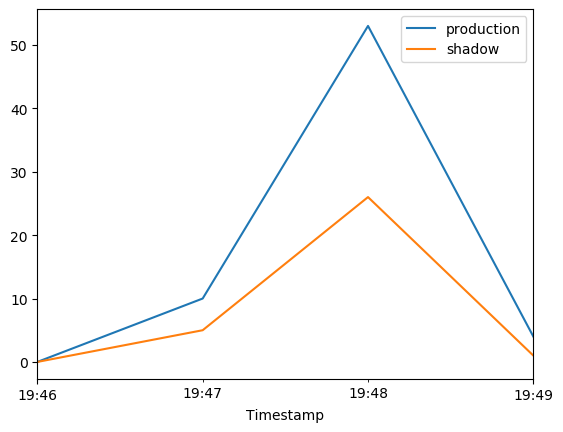

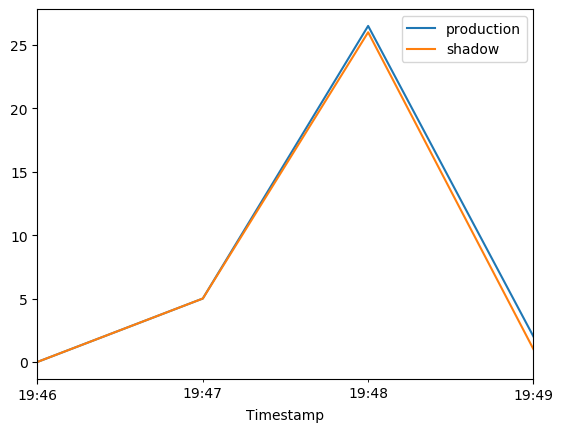

In [31]:
invocations = plot_endpoint_invocation_metrics(endpoint_name, "Invocations", "Sum")
invocations_per_instance = plot_endpoint_invocation_metrics(
    endpoint_name, "InvocationsPerInstance", "Sum"
)

The Invocation metric refers to the number of invocations sent to the production variant. A fraction of these invocations, specified in the variant weight, are sent to the shadow variant. The invocation per instance is calculated by dividing the total number of invocations by the number of instances in a variant. From the chart above, we can confirm that both the production and shadow variants are receiving invocation requests according to the weights specified in the endpoint config. 

Next let us compare the model latency between the production and shadow variants. Model latency is the time taken by a model to respond as viewed from SageMaker.

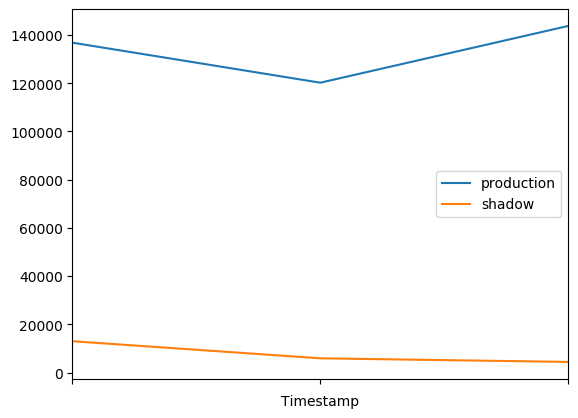

In [32]:
model_latency = plot_endpoint_invocation_metrics(endpoint_name, "ModelLatency", "Average")

Using the chart above, we can observe how the model latency of the shadow variant compares with the production variant without exposing end users to the shadow variant. 

We expect the overhead latency to be comparable across production and shadow variants. Overhead latency is the interval measured from the time SageMaker receives the request until it returns a response to the client, minus the model Latency. 

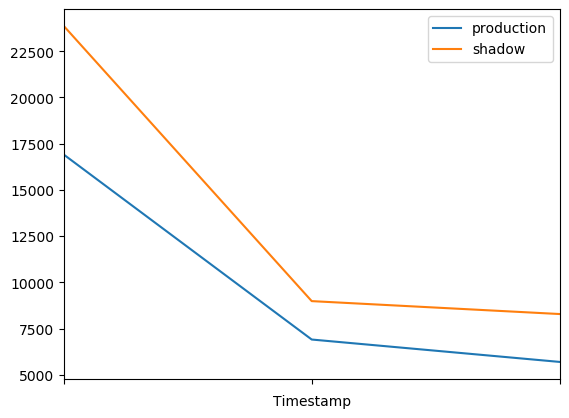

In [33]:
overhead_latency = plot_endpoint_invocation_metrics(endpoint_name, "OverheadLatency", "Average")

Finally, let us review the 4xx, 5xx and total model errors returned by the model serving container. 

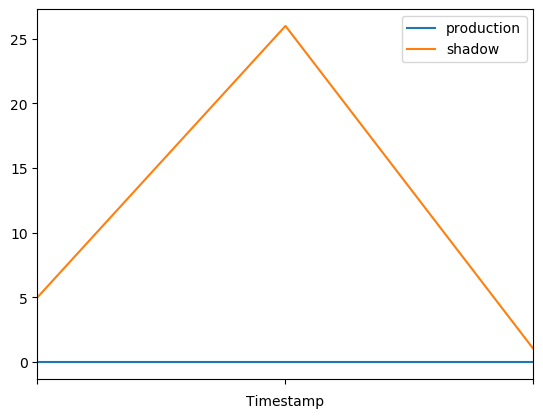

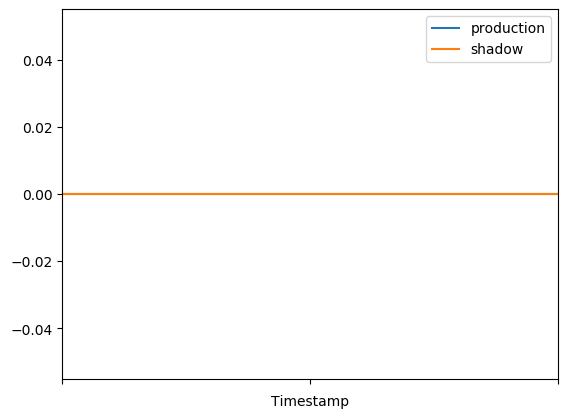

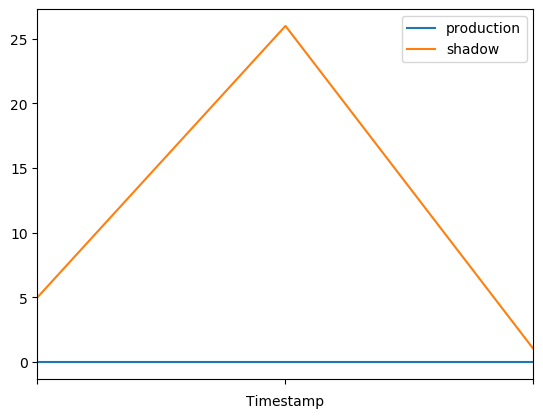

In [34]:
Invocation4xxErrors = plot_endpoint_invocation_metrics(endpoint_name, "Invocation4XXErrors", "Sum")
Invocation5xxErrors = plot_endpoint_invocation_metrics(endpoint_name, "Invocation5XXErrors", "Sum")
Invocation5xxErrors = plot_endpoint_invocation_metrics(
    endpoint_name, "InvocationModelErrors", "Sum"
)

We can consider promoting the shadow model if we do not see any differences in 4xx and 5xx errors between the production shadow variants. 

To promote the shadow model to production, create a new endpoint configuration with current ShadowProductionVariant as the new ProductionVariant and removing the ShadowProductionVariant. This will remove the current ProductionVariant and promote the shadow variant to become the new production variant. As always, all SageMaker updates are orchestrated as blue/green deployments under the hood and there is no loss of availability while performing the update. Optionally, you can leverage [Deployment Guardrails](https://docs.aws.amazon.com/sagemaker/latest/dg/deployment-guardrails.html) if you want to use all-at-once traffic shifting and auto rollbacks during your update.

In [36]:
promote_ep_config_name = f"PromoteShadow-EpC-{datetime.now():%Y-%m-%d-%H-%M-%S}"

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=promote_ep_config_name,
    ProductionVariants=[
        {
            "VariantName": shadow_variant_name,
            "ModelName": roberta_model_name,
            "InstanceType": deploy_instance_type,
            "InitialInstanceCount": 2,
            "InitialVariantWeight": 1.0,
        }
    ],
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-west-2:757967535041:endpoint-config/promoteshadow-epc-2023-05-09-19-51-29


In [37]:
update_endpoint_api_response = sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=promote_ep_config_name,
)

wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service
........
Done!


{'EndpointName': 'xgb-prod-shadow-2023-05-09-19-44-00',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:757967535041:endpoint/xgb-prod-shadow-2023-05-09-19-44-00',
 'EndpointConfigName': 'PromoteShadow-EpC-2023-05-09-19-51-29',
 'ProductionVariants': [{'VariantName': 'shadow',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04',
     'ResolvedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-inference@sha256:17e776fd3295cc6dfee4e122618f5bab7ef04e87ed0490ce6b64722a60f03333',
     'ResolutionTime': datetime.datetime(2023, 5, 9, 19, 51, 33, 187000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 2,
   'DesiredInstanceCount': 2}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 5, 9, 19, 44, 0, 672000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 5, 9, 19, 55,

If you do not want to create multiple endpoint configurations and want SageMaker to manage the end to end workflow of creating, managing, and acting on the results of the shadow tests, consider using the SageMaker Inference Experiement APIs/Console experience. As stated earlier, they enable you to setup shadow tests for a predefined duration of time, monitor the progress through a live dashboard, presents clean up options upon completion, and act on the results. To get started, please navigate to the 'Shadow Tests' section of the SageMaker Inference console. 

## Cleanup

If you do not plan to use this endpoint further, you should delete the endpoint to avoid incurring additional charges and clean up other resources created in this notebook.

In [ ]:
# sm.delete_endpoint(EndpointName=endpoint_name)
# sm.delete_endpoint_config(EndpointConfigName=ep_config_name)
# sm.delete_endpoint_config(EndpointConfigName=promote_ep_config_name)
# sm.delete_model(ModelName=model_name)
# sm.delete_model(ModelName=model_name2)